<a href="https://colab.research.google.com/github/ericdasse28/loan-prediction/blob/master/Pr%C3%A9diction_de_loyer_avec_arrondissement.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prédiction du loyer sur Paris en fonction de la surface de l'appartement et de l'arrondissement

In [32]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.ticker import AutoMinorLocator
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

## Première phase : Exploration/nettoyage des données

In [2]:
# Récupération des données
raw_data = pd.read_csv('house_data.csv')
raw_data.shape

(827, 3)

In [3]:
# Vue d'ensemble des données
raw_data.head()

,price,surface,arrondissement
0,1820,46.1,1.0
1,1750,41.0,1.0
2,1900,55.0,1.0
3,1950,46.0,1.0
4,1950,49.0,1.0


In [4]:
# Résumé des données brutes
raw_data.describe()

,price,surface,arrondissement
count,827.000000,822.000000,822.000000
mean,2007.342201,58.045925,4.142336
std,1890.894229,44.827522,3.202151
min,390.000000,10.000000,1.000000
25%,1050.000000,28.655000,2.000000
50%,1567.000000,46.100000,3.000000
75%,2346.000000,73.000000,4.000000
max,25000.000000,415.000000,10.000000


On peut déjà observer qu'il y a des valeurs manquantes pour les surfaces et les arrondissements. Supprimons ces lignes

In [7]:
# Suppression des lignes comportant des valeurs manquantes
data_na = raw_data.dropna()

# On réindexe
data_na = data_na.reset_index(drop=True)

data_na.shape

(822, 3)

In [6]:
# Les différents arrondissements de Paris apparaissant dans le jeu de données
data_na['arrondissement'].unique()

array([ 1.,  2.,  3.,  4., 10.])

Donc les différents arrondissements qui apparaissent dans les données sont le 1er, le 2ème, le 3ème, le 4ème et le 10ème

Maintenant, il serait intéressant de visualiser les données que nous avons nettoyées. 
Affichons le nuage de points correspondant au loyer en fonction de la surface (avec une coloration correspondant aux arrondissements)

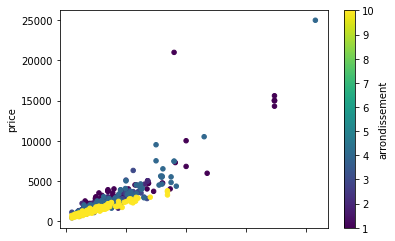

In [19]:
data_na.plot.scatter('surface', 'price', c='arrondissement', colormap='viridis')

On constate que le loyer évolue de façon linéaire en fonction des prix. Par contre, pour des prix au-delà de 8000 € environ, nous avons beaucoup d'outliers. Pour une plus grande simplicité d'analyse, nous ne considèrerons pas ces données

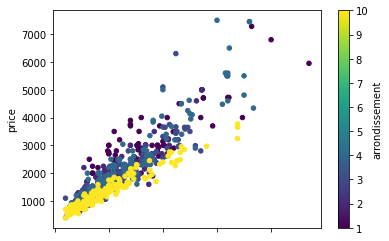

In [21]:
house_data = data_na[data_na['price'] < 8000]
house_data.reset_index(drop=True)
house_data.plot.scatter("surface", "price", c="arrondissement",
                        colormap="viridis")

**On note clairement un problème d'hétéroscédascticité dans ces données. On y reviendra plus tard**

On affiche maintenant la variable prédite (loyer) en fonction de l'arrondissement

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


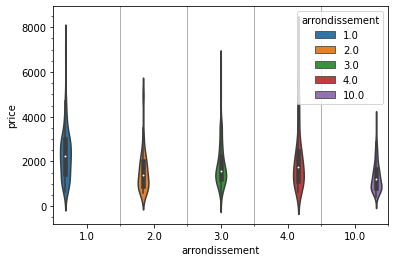

In [27]:
ax1 = sns.violinplot("arrondissement", "price", data=house_data, 
                     hue="arrondissement")
ax1.minorticks_on()
ax1.xaxis.set_minor_locator(AutoMinorLocator(2))
ax1.grid(which='minor', axis='x', linewidth=1)

La répartition des prix semblent la même pour chaque arrondissement, avec moins de loyers élevés (+volatiles) dans le 10ème. Si on considère qu'on a des échantillons représentatifs, il faut de toute façon croiser avec la surface pour avoir une vision plus claire

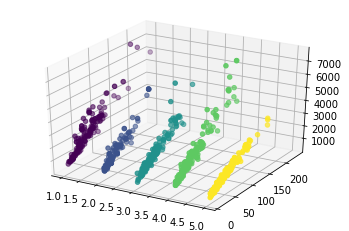

In [29]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure().gca(projection='3d')

# Pour faciliter la visualisation, on va changer la valeur de l'arrondissement (10)
tmp_arr = house_data['arrondissement'][:]
tmp_arr[tmp_arr == 10] = 5

fig.scatter(tmp_arr, house_data["surface"], house_data["price"], c=tmp_arr,
            cmap="viridis")

# Modélisation

On va effectuer une régression spécifique sur chaque arrondissement pour avoir plus de précision. D'abord, séparation du jeu de données d'entraînement du jeu de données de test

In [31]:
X_train, X_test, y_train, y_test = train_test_split(
    house_data[["surface", "arrondissement"]],
    house_data[["price"]],
    train_size=.8)

Créons ensuite la baseline et calculons le R2 (la somme quadratique des résidus), comme valeur d'évaluation de notre régression

In [ ]:
lr = LinearRegression()
lr_baseline = lf.fit(X_train[["surface"]], y_train)


## One-hot encoding

Les arrondissements étaient des données de type catégorique, nous allons les convertir en one-hot encoding

In [ ]:
# Pour plus de propreté, commençons par mettre les arrondissements au format int
# plutôt que float
house_data['arrondissement'] = house_data['arrondissement'].astype('int')
house_data['arrondissement'].unique()

array([ 1,  2,  3,  4, 10])

In [ ]:
# Passage au one-hot encoding
one_hot_arrondissements = pd.get_dummies(house_data['arrondissement'])

# On retire la colonne correspondant à l'arrondissement
# On crée une variable pour contenir les arrondissements de notre jeu de données
# sous la forme d'un one-hot encoding
OH_house_data = house_data.drop('arrondissement', axis=1)

# Concaténation de l'encoding à notre jeu de données
OH_house_data = OH_house_data.join(one_hot_arrondissements)

OH_house_data.head()

,price,surface,1,2,3,4,10
0,1820,46.1,1,0,0,0,0
1,1750,41.0,1,0,0,0,0
2,1900,55.0,1,0,0,0,0
3,1950,46.0,1,0,0,0,0
4,1950,49.0,1,0,0,0,0


## Entraînement du modèle

In [ ]:
features = [col for col in OH_house_data.columns if col != 'price']

# Tout d'abord, séparons les features de la cible de prédiction
X = OH_house_data[features]
y = OH_house_data['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.8)

In [ ]:
X_train.head()

,surface,1,2,3,4,10
708,60.0,0,0,0,0,1
107,110.0,1,0,0,0,0
378,40.0,0,0,1,0,0
746,29.4,0,0,0,0,1
580,40.0,0,0,0,1,0


In [ ]:
y_train.head()

708    1670
107    2900
378    1390
746    1050
580    2000
Name: price, dtype: int64

In [ ]:
X_train.shape

(650, 6)

In [ ]:
y_train.shape

(650,)

In [ ]:
# Construction du modèle de regression linéaire
model = LinearRegression()
model.fit(X_train, y_train)
model.score(X_train, y_train)

0.833641779413364

On obtient un score d'environ 83.36 % à l'entraînement (évaluation avec le coefficient de détermination R2)

In [ ]:
# Évaluation sur les données de test
model.score(X_test, y_test)

0.8657220347621318

Les performances sont tout aussi bonnes sur les données de test avec un score d'environ 86.57%

In [ ]:
# TODO : Améliorer davantage le modèle